# JPEG Compression

1. Read the JPEG for a while: \
I. wiki: https://en.wikipedia.org/wiki/JPEG \
II. Documentation: 
https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/jpegUpToQuant.html

**JPEG Algorithm Summarized:** \
a. Convert RGB to YCbCr: Separate luminance (Y) from chrominance (Cb, Cr) since human vision is more sensitive to brightness.

b. Chroma Subsampling (4:2:0): Reduce chrominance resolution by averaging blocks of pixels.

c. Divide into 8x8 Blocks: Process the image in small blocks for DCT computation.

d. Apply Discrete Cosine Transform (DCT): Convert spatial data into frequency components.

e. Quantization: Reduce high-frequency components (lossy step) using a quantization matrix.

f. Zigzag Scanning: Reorder coefficients for efficient entropy encoding.

g. Run-Length & Huffman Encoding: Compress data further (not always visualized).

In [222]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
from scipy.fftpack import dct, idct
import imutils
from math import sqrt, ceil, pow, log10

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
img_url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"
imgBGR = imutils.url_to_image(img_url)
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

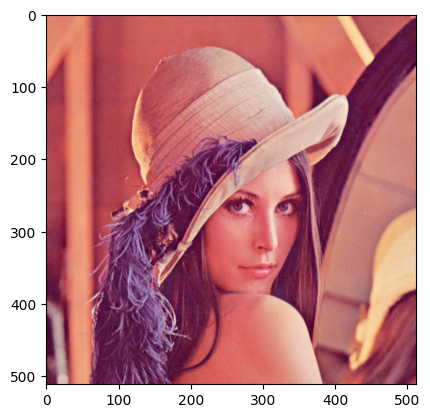

In [3]:
plt.imshow(imgRGB)

In [4]:
imgYCrCb = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2YCrCb)
Y, Cr, Cb = cv2.split(imgYCrCb)

In [ ]:
def plt_result(imgs, imgs_title = None, cmap = "gray"):

    if len(imgs) == 2:
        fig, axis = plt.subplots(1, 2, figsize=(10, 8))
        for ind, img in enumerate(imgs):
            axis[ind].imshow(img, cmap=cmap)
            if imgs_title:
                axis[ind].set_title(imgs_title[ind])

        fig.show()
        return
    
    grid_size = ceil(sqrt(len(imgs)))
    fig, axis = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    current_count = 0
    for w in range(grid_size):
        for h in range(grid_size):

            if current_count < len(imgs):
                axis[w][h].imshow(imgs[w*grid_size + h], cmap=cmap)

                if imgs_title:
                    axis[w][h].set_title(imgs_title[w*grid_size + h])

                current_count += 1

    fig.show()



/var/folders/nw/jjj9j5ns1xz17455t33jytch0000gn/T/ipykernel_6752/977275739.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


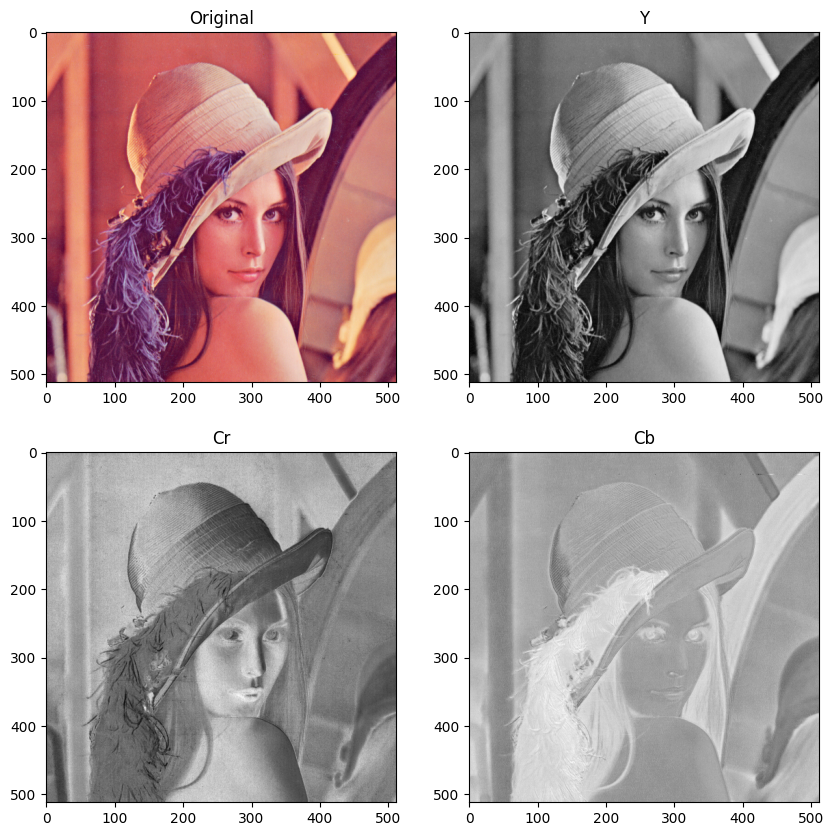

In [6]:
plt_result([imgRGB, Y, Cr, Cb], ["Original", "Y", "Cr", "Cb"])

**Chroma Subsampling (4:2:0)**

In [7]:
def subsample_callback(img_s, kernel, callback):

    height, width = img_s.shape
    stepH, stepW = kernel.shape
    x, y = 0, 0

    # print(height, width)
    # print(stepH, stepW)
    result = np.zeros((height // stepH, width // stepW))

    for h in range(0, height, stepH):
        y = 0
        for w in range(0, width, stepW):
            img_patch = img_s[h:h+stepH, w:w+stepW]

            result[x][y] = callback(img_patch, kernel)
            y += 1

        x += 1

    return result

In [8]:
Crsubsamp = subsample_callback(Cr, np.array([[1, 1], [1, 1]]), lambda ip, k : int(np.average(ip * k)))

In [9]:
Cr.shape, Crsubsamp.shape

((512, 512), (256, 256))

In [10]:
Cbsubsamp = subsample_callback(Cb, np.array([[1, 1], [1, 1]]), lambda ip, k : int(np.average(ip * k)))

In [11]:
Cb.shape, Cbsubsamp.shape

((512, 512), (256, 256))

/var/folders/nw/jjj9j5ns1xz17455t33jytch0000gn/T/ipykernel_6752/977275739.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


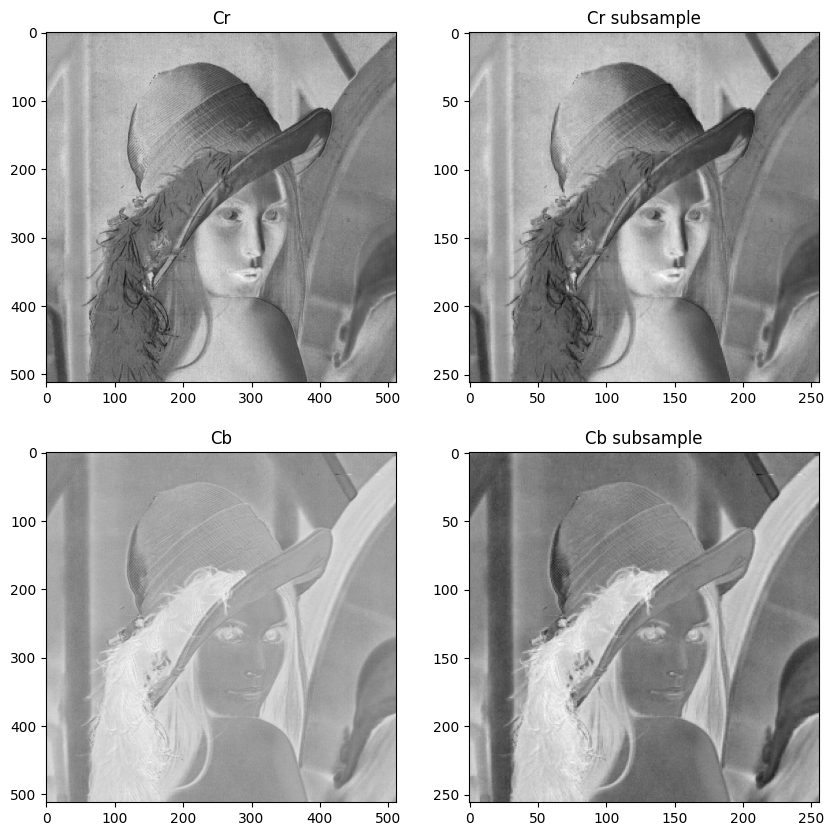

In [12]:
plt_result([Cr, Crsubsamp, Cb, Cbsubsamp], ["Cr", "Cr subsample", "Cb", "Cb subsample"])

In [13]:
def block_sample(img_s, block_size):

    # order is in height, width so.. decoding in same order
    height, width = img_s.shape
    stepH, stepW = block_size

    img_blocks = []
    for h in range(0, height, stepH):
        for w in range(0, width, stepW):
            img_patch = img_s[h:h+stepH, w:w+stepW]

            img_blocks.append(img_patch)

    return img_blocks

In [14]:
block_size = (8, 8)
img8x8blocks = block_sample(Y, block_size)

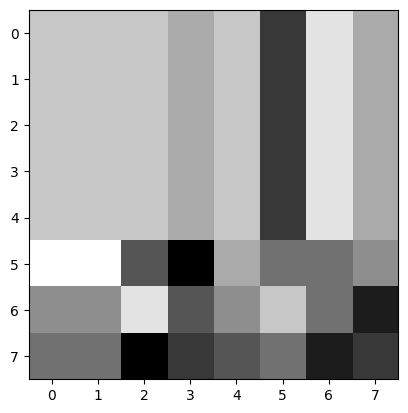

In [15]:
plt.imshow(img8x8blocks[0], cmap="gray")

In [ ]:
dct_coeffs = []

def dct_blocks(blocks):
    result = []

    for block8x8 in blocks:
        # making range across [-128, 127]
        g = block8x8 - 128
        dct_coeff = dct(dct(g.T, norm="ortho").T, norm="ortho")
        result.append(dct_coeff)

    return result

dct_coeffs = dct_blocks(img8x8blocks)

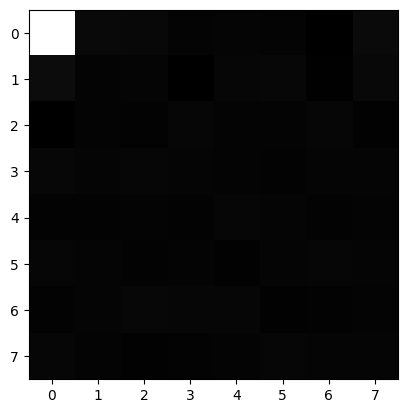

In [77]:
plt.imshow(dct_coeffs[0], cmap="gray")

In [66]:
Q = np.array(
    [[16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]]
)

In [157]:
quantized_vals = []

def quantize_blocks(blocks, Q):
    
    result = []
    for block in blocks:

        round_val = block / Q

        result.append(np.round(round_val))

    return result

quantized_vals = quantize_blocks(dct_coeffs, Q)

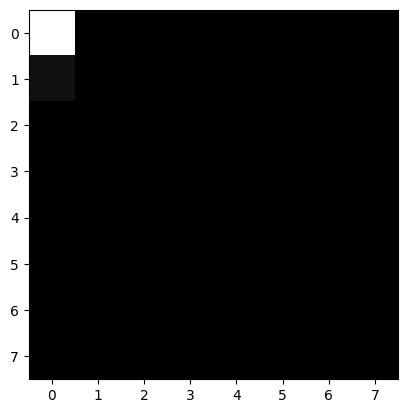

In [158]:
plt.imshow(quantized_vals[0], cmap="gray")

**Now doing reverse portion (i.e Decoding...)**

In [1]:
dequantized_vals = []

def dequantize_blocks(quant_blocks, Q):

    result = []
    for quant_block in quant_blocks:
        result.append(quant_block * Q)

    return result

dequantized_vals = dequantize_blocks(quantized_vals, Q)

NameError: name 'quantized_vals' is not defined

In [160]:
reconstruct_blocks = []

def idct_blocks(dequant_blocks):

    result = []

    for dequant_block in dequant_blocks:
        reconstruct_block = idct(idct(dequant_block.T, norm="ortho").T, norm="ortho") + 128
        result.append(reconstruct_block)

    return result

reconstruct_blocks = idct_blocks(dequantized_vals)

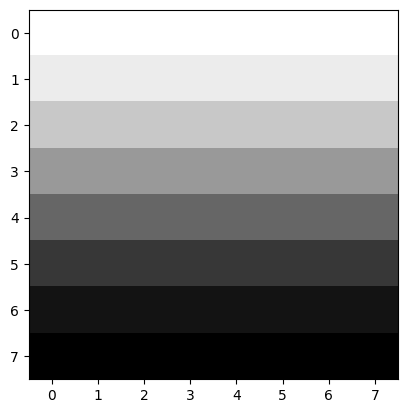

In [161]:
plt.imshow(reconstruct_blocks[0], cmap="gray")

In [72]:
len(reconstruct_blocks)

4096

In [ ]:
reconstruct_img = None

def blocks_join(imgblocks, img_size):
    
    result = np.zeros(img_size)
    height, width = img_size
    blockH, blockW = imgblocks[0].shape

    ind = 0
    for h in range(0, height, blockH):
        for w in range(0, width, blockW):
            # print(h, w, imgblocks[h*blockH + w].shape)
            result[h:h+blockH, w:w+blockW] = imgblocks[ind]
            ind += 1

    return result


In [74]:
reconstruct_img = blocks_join(reconstruct_blocks, (512, 512))

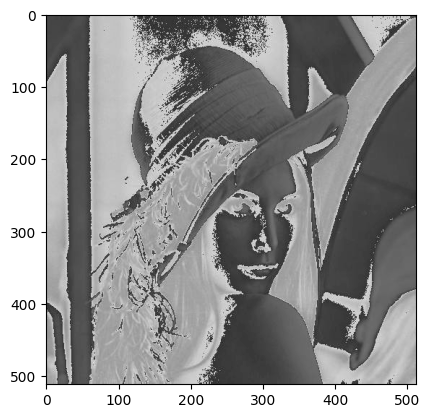

In [75]:
plt.imshow(reconstruct_img, cmap="gray")

In [83]:
flatten_test = np.array([[1, 2], [3, 4], [5, 6]])
flatten_test.flatten()

array([1, 2, 3, 4, 5, 6])

In [87]:
# this is the 8x8 array with index given as the order for zig-zag run length encoding..
zig_zag_indices = np.array([
    0, 1, 1*8, 2*8, 1*8 + 1, 2, 3, 1*8 + 2,
    2*8 + 1, 3*8, 4*8, 3*8 + 1, 2*8 + 2, 1*8 + 3, 4, 5,
    1*8 + 4, 2*8 + 3, 3*8 + 2, 4*8 + 1, 5*8, 6*8, 5*8 + 1, 4*8 + 2,
    3*8 + 3, 2*8 + 4, 1*8 + 5, 6, 7, 1*8 + 6, 2*8 + 5, 3*8 + 4,
    4*8 + 3, 5*8 + 2, 6*8 + 1, 7*8, 7*8 + 1, 6*8 + 2, 5*8 + 3, 4*8 + 4,
    3*8 + 5, 2*8 + 6, 1*8 + 7, 2*8 + 7, 3*8 + 6, 4*8 + 5, 5*8 + 4, 6*8 + 3,
    7*8 + 2, 7*8 + 3, 6*8 + 4, 5*8 + 5, 4*8 + 6, 3*8 + 7, 4*8 + 7, 5*8 + 6,
    6*8 + 5, 7*8 + 4, 7*8 + 5, 6*8 + 6, 5*8 + 7, 6*8 + 7, 7*8 + 6, 7*8+7
])
zig_zag_indices = zig_zag_indices.reshape((8, 8))
zig_zag_indices

array([[ 0,  1,  8, 16,  9,  2,  3, 10],
       [17, 24, 32, 25, 18, 11,  4,  5],
       [12, 19, 26, 33, 40, 48, 41, 34],
       [27, 20, 13,  6,  7, 14, 21, 28],
       [35, 42, 49, 56, 57, 50, 43, 36],
       [29, 22, 15, 23, 30, 37, 44, 51],
       [58, 59, 52, 45, 38, 31, 39, 46],
       [53, 60, 61, 54, 47, 55, 62, 63]])

In [121]:
class RLEStruct:
    def __init__(self, val, count = 0):
        self.val = val
        self.count = count
    
    def increment(self, over = 1):
        self.count += over
    
    def equal_check(self, check_val) -> bool:
        return check_val == self.val
    
    def __repr__(self):
        return f"(Value: {self.val}, Count: {self.count})"

    def __str__(self):
        return f"(Value: {self.val}, Count: {self.count})"

In [174]:
def run_length_encode(arr : np.ndarray, ind_mat: np.ndarray):

    assert arr.shape == ind_mat.shape, "Unable to process incompatible shapes"
    
    result = []
    arr = arr.flatten()
    ind_mat = ind_mat.flatten()

    rle_holder = RLEStruct(arr[0])

    for ind in ind_mat:
        current_val = arr[ind]
        if rle_holder.equal_check(current_val):
            rle_holder.increment()
            continue
        else:
            result.append(rle_holder)  
            rle_holder = RLEStruct(current_val, 1)

    # if the first value is repeated all the way then append in last...
    result.append(rle_holder)  


    return result
          

In [201]:
def run_length_decode(encoded : np.ndarray, ind_mat : np.ndarray):

    # for every element in list we have the RLEStruct
    temp_vals = []
    result = np.zeros_like(ind_mat).flatten()
    # print(result.shape)

    for rle_holder in encoded:
        # print(rle_holder)
        for _ in range(rle_holder.count):
            temp_vals.append(rle_holder.val)
        

    # print(len(result), len(temp_vals))
    for i, ind in enumerate(ind_mat.flatten()):
        result[ind] = temp_vals[i]
    
    return result.reshape((ind_mat.shape))


In [176]:
# test_run_length = np.zeros((8, 8))
# rlencode = run_length_encode(test_run_length, zig_zag_indices)
# print(rlencode)
# rldecode = run_length_decode(rlencode, zig_zag_indices)
# print(rldecode)

In [177]:
# RLEStruct(5, 1)

In [178]:
# np.array(dct_coeffs[0], dtype=np.int32)

In [179]:
# result = run_length_encode(dct_coeffs[0], zig_zag_indices)
# result

In [ ]:
def jpeg_compress(imgRGB, Q, subsample=True):

    # now Y, Cr, Cb are ready for other processing
    Y, Cr, Cb = cv2.split(cv2.cvtColor(imgRGB, cv2.COLOR_RGB2YCrCb))

    if subsample:
        identity_kernel = np.array([
            [1, 1],
            [1, 1]
        ])
        Cr = subsample_callback(Cr, identity_kernel, lambda ip, k : np.average(ip * k))
        Cb = subsample_callback(Cb, identity_kernel, lambda ip, k : np.average(ip * k))

    blocks8x8Y = block_sample(Y, (8, 8))

    dct_coeffs = dct_blocks(blocks8x8Y)
    # dct_coeffs = np.array(dct_coeffs, dtype=np.int32)
    quant_dct_coeffs = quantize_blocks(dct_coeffs, Q)
    # print((quant_dct_coeffs[0]))

    coded_dct = []
    for qdct_coeff in quant_dct_coeffs:
        coded = run_length_encode(qdct_coeff, zig_zag_indices)
        # print(coded)
        coded_dct.append(coded)

    # for now we are simply returning the coded dct (i.e RLE based), subsampled (opt) Cr
    return coded_dct, Cr, Cb
    


In [185]:
coded_dct, Cr, Cb = jpeg_compress(imgRGB, Q)

In [186]:
coded_dct

[[(Value: 16.0, Count: 1),
  (Value: 0.0, Count: 1),
  (Value: 1.0, Count: 1),
  (Value: -0.0, Count: 61)],
 [(Value: 15.0, Count: 1),
  (Value: 2.0, Count: 1),
  (Value: 1.0, Count: 1),
  (Value: -0.0, Count: 61)],
 [(Value: 14.0, Count: 1), (Value: 1.0, Count: 2), (Value: -0.0, Count: 61)],
 [(Value: 13.0, Count: 1),
  (Value: 0.0, Count: 4),
  (Value: 1.0, Count: 1),
  (Value: -0.0, Count: 58)],
 [(Value: 15.0, Count: 1),
  (Value: -2.0, Count: 1),
  (Value: 0.0, Count: 3),
  (Value: 1.0, Count: 1),
  (Value: 0.0, Count: 58)],
 [(Value: 21.0, Count: 1),
  (Value: -2.0, Count: 1),
  (Value: -0.0, Count: 3),
  (Value: -1.0, Count: 1),
  (Value: 0.0, Count: 58)],
 [(Value: 20.0, Count: 1),
  (Value: 3.0, Count: 1),
  (Value: 0.0, Count: 3),
  (Value: -1.0, Count: 1),
  (Value: 0.0, Count: 58)],
 [(Value: 56.0, Count: 1),
  (Value: -69.0, Count: 1),
  (Value: -8.0, Count: 1),
  (Value: 3.0, Count: 2),
  (Value: 19.0, Count: 1),
  (Value: 12.0, Count: 1),
  (Value: 9.0, Count: 1),
  (Val

In [246]:
# get the original RGB image
def jpeg_decompress(jpeg_comp, Q, img_size, subsample = True):
    
    coded_dct, Cr, Cb = jpeg_comp

    decoded_dct = []
    for dqdct_coeff in coded_dct:
        decoded = run_length_decode(dqdct_coeff, zig_zag_indices)
        # print(coded)
        decoded_dct.append(decoded)
    
    dequant_dct_coeffs = dequantize_blocks(decoded_dct, Q)

    idct_coeffs = idct_blocks(dequant_dct_coeffs)

    combinedY = blocks_join(idct_coeffs, img_size)

    if subsample:
        # print(Cr.shape, Cb.shape)
        Cr, Cb = cv2.resize(Cr, (Cr.shape[0] * 2, Cr.shape[-1] * 2)), cv2.resize(Cb, (Cb.shape[0] * 2, Cb.shape[-1] * 2))

    # print(combinedY.shape, combinedY.dtype, Cr.shape, Cr.dtype, Cb.shape, Cb.dtype)
    combinedY = np.array(combinedY, dtype=np.uint8)
    YCrCb = cv2.merge([combinedY, Cr, Cb])
    print(YCrCb.shape)
    YCrCb = np.array(YCrCb, dtype=np.uint8)
    
    return cv2.cvtColor(YCrCb, cv2.COLOR_YCR_CB2RGB)

In [211]:
imgRGB.shape

(512, 512, 3)

In [212]:
img_comp = jpeg_decompress((coded_dct, Cr, Cb), Q, Y.shape)

(512, 512, 3)


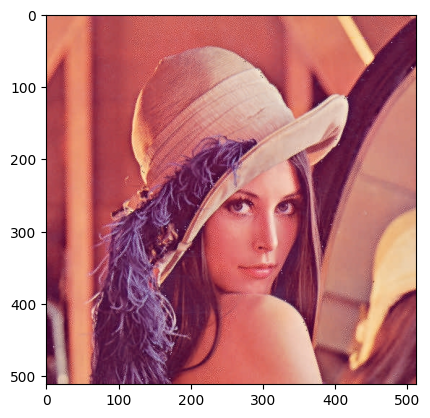

In [213]:
plt.imshow(img_comp)

In [223]:
def psnr(org, comp):

    mse = np.mean((org - comp) ** 2)

    # if MSE is zero means no noise is present in signal .. so PSNR no importance
    if(mse == 0):
        return 100
    
    # here max pixel is hardcoded to be the 255.0
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
    

In [225]:
psnr_val = psnr(imgRGB, img_comp)
print(f"PSNR value is {round(psnr_val, 3)} dB")

PSNR value is 32.033 dB


## Now testing with different Q values

In [214]:
# note: this might produce random result, (chrominance quantization table)
nQ = np.array(
    [[17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]]
)

In [215]:
ncoded_dct, nCr, nCb = jpeg_compress(imgRGB, nQ)

In [216]:
ncoded_dct

[[(Value: 15.0, Count: 1), (Value: 0.0, Count: 63)],
 [(Value: 14.0, Count: 1), (Value: 1.0, Count: 2), (Value: -0.0, Count: 61)],
 [(Value: 13.0, Count: 1),
  (Value: 0.0, Count: 1),
  (Value: 1.0, Count: 1),
  (Value: -0.0, Count: 61)],
 [(Value: 12.0, Count: 1), (Value: 0.0, Count: 63)],
 [(Value: 15.0, Count: 1), (Value: -1.0, Count: 1), (Value: 0.0, Count: 62)],
 [(Value: 20.0, Count: 1), (Value: -1.0, Count: 1), (Value: -0.0, Count: 62)],
 [(Value: 19.0, Count: 1),
  (Value: 2.0, Count: 1),
  (Value: 0.0, Count: 3),
  (Value: -1.0, Count: 1),
  (Value: 0.0, Count: 58)],
 [(Value: 53.0, Count: 1),
  (Value: -42.0, Count: 1),
  (Value: -5.0, Count: 1),
  (Value: 2.0, Count: 2),
  (Value: 8.0, Count: 1),
  (Value: 4.0, Count: 1),
  (Value: 5.0, Count: 1),
  (Value: -0.0, Count: 4),
  (Value: -1.0, Count: 2),
  (Value: -2.0, Count: 1),
  (Value: -0.0, Count: 1),
  (Value: -1.0, Count: 1),
  (Value: 0.0, Count: 9),
  (Value: 1.0, Count: 2),
  (Value: -0.0, Count: 1),
  (Value: 1.0, Co

In [219]:
nimg_comp = jpeg_decompress((ncoded_dct, nCr, nCb), nQ, Y.shape)

(512, 512, 3)


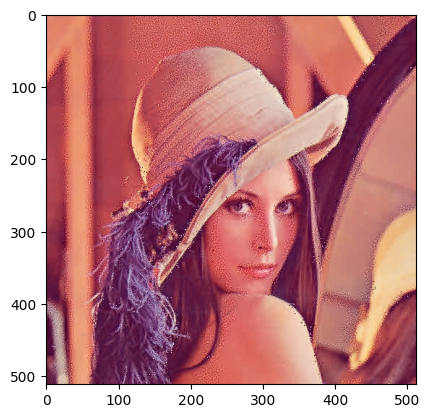

In [220]:
plt.imshow(nimg_comp)

In [227]:
print(f"PSNR of nQ is: {psnr(imgRGB, nimg_comp)} dB")

PSNR of nQ is: 31.466118080678314 dB


/var/folders/nw/jjj9j5ns1xz17455t33jytch0000gn/T/ipykernel_6752/977275739.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


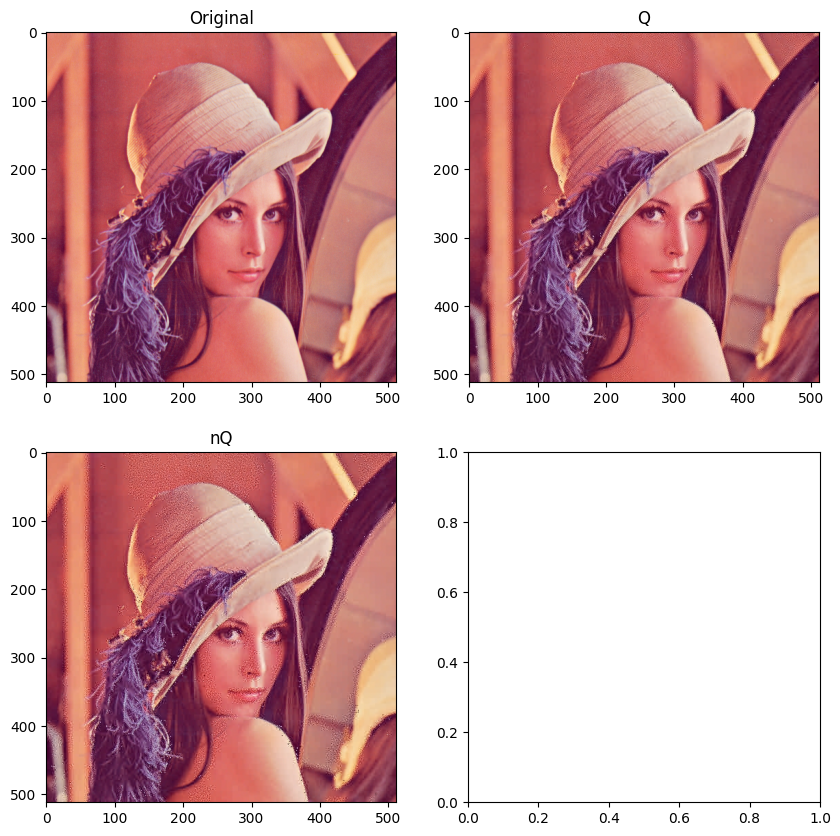

In [221]:
plt_result([imgRGB, img_comp, nimg_comp], ["Original", "Q", "nQ"])

## Without Chromasubsampling

In [229]:
wc_coded_dct, wc_Cr, wc_Cb = jpeg_compress(imgRGB, Q, False)

In [233]:
wc_Cb.shape

(512, 512)

In [247]:
wc_img_comp = jpeg_decompress((wc_coded_dct, wc_Cr, wc_Cb), Q, Y.shape, False)

(512, 512, 3)


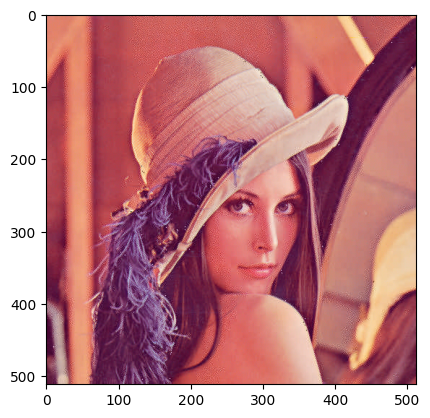

In [248]:
plt.imshow(wc_img_comp)

In [249]:
print(f"PSNR without subsample Chroma: {psnr(imgRGB, wc_img_comp)} dB")

PSNR without subsample Chroma: 32.52284722056244 dB


### cv2 Compression 

In [257]:
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 75]

In [258]:
cv2_result, encimg = cv2.imencode('.jpeg', imgRGB, encode_param)

In [259]:
cv2_img_comp = cv2.imdecode(encimg, 1)

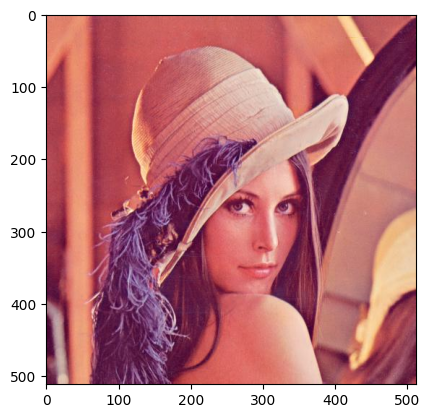

In [260]:
plt.imshow(cv2_img_comp)

/var/folders/nw/jjj9j5ns1xz17455t33jytch0000gn/T/ipykernel_6752/977275739.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


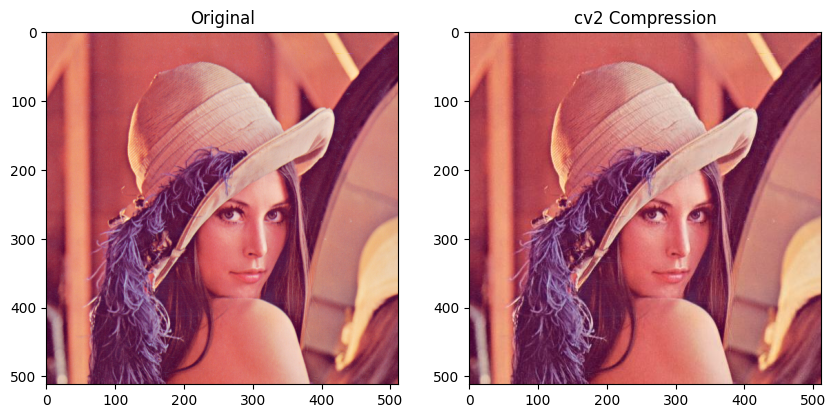

In [261]:
plt_result([imgRGB, cv2_img_comp], ["Original", "cv2 Compression"])

In [265]:
print(f"PSNR without subsample Chroma: {psnr(imgRGB, cv2_img_comp)} dB | with params (code, quality%): {encode_param}")

PSNR without subsample Chroma: 34.18708173383173 dB | with params (code, quality%): [1, 75]
